In [12]:
# =====================================================
# WEEK 9 (PCA)
# Hands-on: PCA in scikit-learn (Hotel Bookings dataset)
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [14]:
# -------------------------------
# 1) Load dataset
# -------------------------------
url = "https://raw.githubusercontent.com/swapnilsaurav/Dataset/refs/heads/master/hotel_bookings.csv"
df = pd.read_csv(url)

print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())


Raw shape: (119390, 33)
Columns: ['id', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']


In [15]:
# -------------------------------
# 2) Keep numeric features + target together (prevents misalignment bugs)
# -------------------------------
target_col = "is_canceled"

numeric_df = df.select_dtypes(include=["int64", "float64"]).copy()

# Safety: drop rows where target missing (rare but keeps alignment perfect)
numeric_df = numeric_df.dropna(subset=[target_col])

X = numeric_df.drop(columns=[target_col])
y = numeric_df[target_col].astype(int)

print("\nNumeric-only shape (incl target):", numeric_df.shape)
print("X shape:", X.shape, "y shape:", y.shape)



Numeric-only shape (incl target): (119380, 21)
X shape: (119380, 20) y shape: (119380,)


In [16]:
# -------------------------------
# 3) Train-test split (best practice)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)



In [17]:
# -------------------------------
# 4) Impute missing values (median for numeric)
# -------------------------------
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# -------------------------------
# 5) Scale data (MANDATORY for PCA)
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)



In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


# =========================================================
# 1) Fit PCA with ALL components (to analyze variance curve)
# =========================================================
pca_full = PCA()                      # no n_components => keeps max possible
pca_full.fit(X_train_scaled)          # fit ONLY on training set (no leakage)

explained_var = pca_full.explained_variance_ratio_   # variance each PC explains
cumulative_var = np.cumsum(explained_var)            # cumulative variance



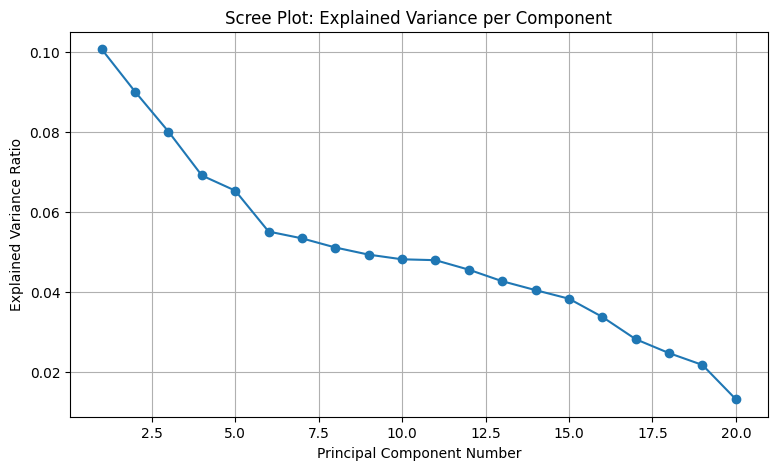

In [19]:
# =========================================================
# 2) Scree plot (Explained variance per component)
# =========================================================
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker="o")
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot: Explained Variance per Component")
plt.grid(True)
plt.show()


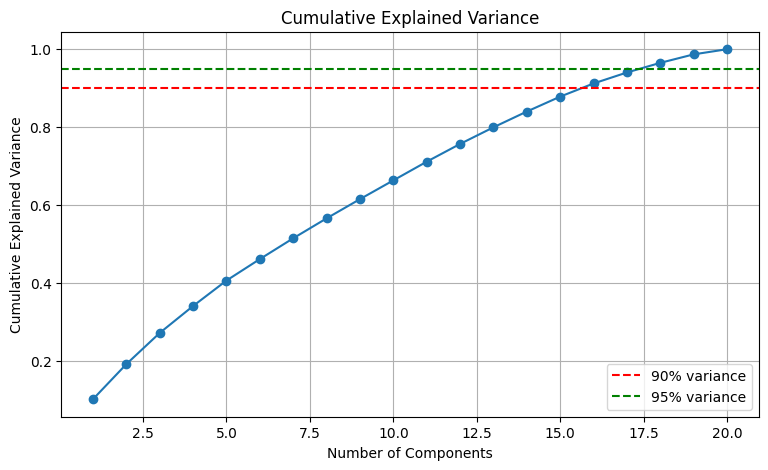

In [20]:
# =========================================================
# 3) Cumulative variance plot (to pick 90% / 95% thresholds)
# =========================================================
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker="o")
plt.axhline(y=0.90, color="r", linestyle="--", label="90% variance")
plt.axhline(y=0.95, color="g", linestyle="--", label="95% variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# =========================================================
# 4) Choose number of components for 90% and 95% variance
# =========================================================
n_90 = int(np.argmax(cumulative_var >= 0.90) + 1)
n_95 = int(np.argmax(cumulative_var >= 0.95) + 1)

print("Components needed for 90% variance:", n_90)
print("Components needed for 95% variance:", n_95)


Components needed for 90% variance: 16
Components needed for 95% variance: 18


In [22]:
# =========================================================
# 5) Evaluate model performance + runtime for different k
#    (Practical / business decision approach)
# =========================================================
def train_eval_with_pca(n_components: int):
    """
    Fit PCA on training data, transform train/test,
    train logistic regression, return metrics & timing.
    """
    # PCA stage
    pca = PCA(n_components=n_components, random_state=42)

    t0 = time.time()
    Xtr_pca = pca.fit_transform(X_train_scaled)   # fit on train
    Xte_pca = pca.transform(X_test_scaled)        # transform test
    pca_time = time.time() - t0

    # Model stage
    model = LogisticRegression(max_iter=1000)

    t1 = time.time()
    model.fit(Xtr_pca, y_train)
    train_time = time.time() - t1

    # Predictions
    proba = model.predict_proba(Xte_pca)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)

    return {
        "n_components": n_components,
        "variance_retained": float(np.sum(pca.explained_variance_ratio_)),
        "pca_time_sec": pca_time,
        "train_time_sec": train_time,
        "accuracy": acc,
        "roc_auc": auc
    }


# Try a few meaningful points:
# - very small k (2) for visualization baseline
# - 90% threshold
# - 95% threshold
# - full feature space (no PCA) for comparison
results = []

for k in [2, n_90, n_95]:
    results.append(train_eval_with_pca(k))

# Baseline: No PCA (model on scaled original features)
t0 = time.time()
base_model = LogisticRegression(max_iter=1000)
base_model.fit(X_train_scaled, y_train)
base_train_time = time.time() - t0

base_proba = base_model.predict_proba(X_test_scaled)[:, 1]
base_pred = (base_proba >= 0.5).astype(int)

results.append({
    "n_components": "No PCA",
    "variance_retained": 1.0,               # by definition (all features)
    "pca_time_sec": 0.0,
    "train_time_sec": base_train_time,
    "accuracy": accuracy_score(y_test, base_pred),
    "roc_auc": roc_auc_score(y_test, base_proba)
})

results_df = pd.DataFrame(results)
print("\n===== PCA Component Choice: Performance & Runtime =====")
print(results_df)




===== PCA Component Choice: Performance & Runtime =====
  n_components  variance_retained  pca_time_sec  train_time_sec  accuracy  \
0            2           0.190922      0.055358        0.109519  0.624895   
1           16           0.912045      0.041664        0.293080  0.727660   
2           18           0.965012      0.032686        0.324277  0.732585   
3       No PCA           1.000000      0.000000        0.580753  0.817289   

    roc_auc  
0  0.577190  
1  0.790836  
2  0.794899  
3  0.889952  


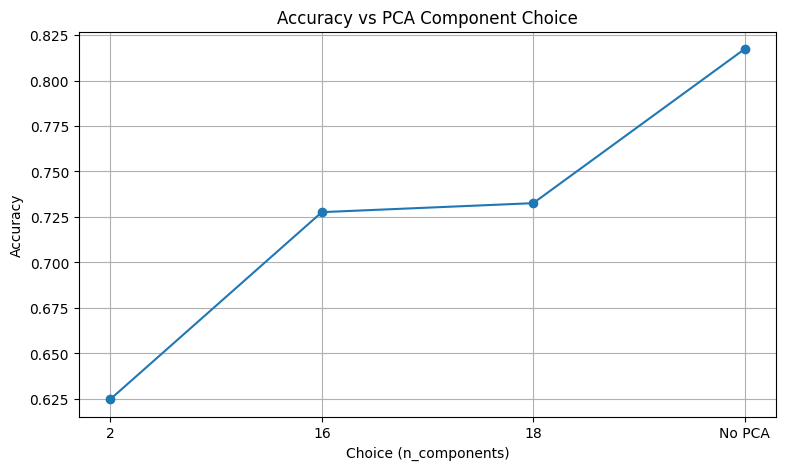

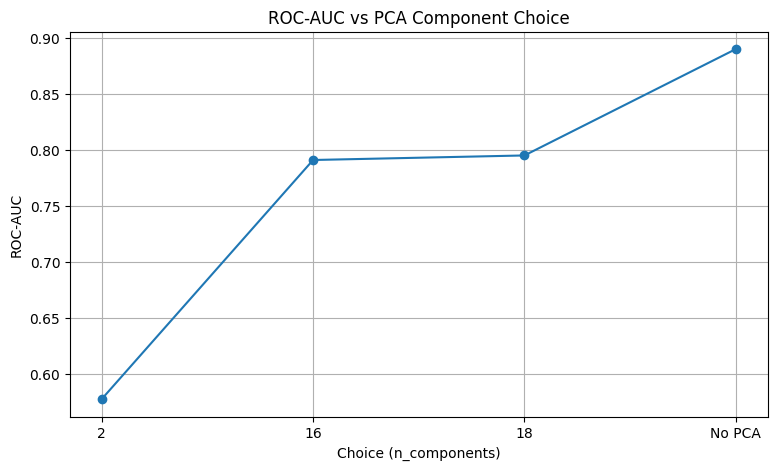

In [23]:
# =========================================================
# 6) Simple visual comparison (Accuracy & AUC vs choice)
# =========================================================
plot_df = results_df.copy()
plot_df["label"] = plot_df["n_components"].astype(str)

plt.figure(figsize=(9, 5))
plt.plot(plot_df["label"], plot_df["accuracy"], marker="o")
plt.xlabel("Choice (n_components)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs PCA Component Choice")
plt.grid(True)
plt.show()

plt.figure(figsize=(9, 5))
plt.plot(plot_df["label"], plot_df["roc_auc"], marker="o")
plt.xlabel("Choice (n_components)")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC vs PCA Component Choice")
plt.grid(True)
plt.show()
